# Auto.Ru cars dataset download

### Imports

In [632]:
import requests
import numpy as np
import json
import sys
import pandas as pd
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt

### Auto.ru API params

Setting URL to the endpoint which loads paginated search results as jsons as discovered via browser inspector. Also setting required headers taken from browser as well, the once which are required based on some experiments

In [5]:
url = "https://auto.ru/-/ajax/desktop/listing/"

headers = {
'Connection': 'keep-alive',
'Content-Length': '1',
'x-csrf-token': 'c98536558d3b1951376b9da7762f4aa6a07b03e799a80859',
'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
'x-requested-with': 'fetch',
'content-type': 'application/json',
'Accept': '*/*',
'Host': 'auto.ru',
'Origin': 'https://auto.ru',
'Accept-Encoding': 'gzip, deflate, br',
'Cookie': r'_csrf_token=c98536558d3b1951376b9da7762f4aa6a07b03e799a80859; autoru_sid=a%3Ag5fde972324r8cvbn65cjs0o2gak57nm.33d19a71ef65ff0f18bd8a60777af61c%7C1608423203006.604800._CEkgolzgDOJn4kSX3ygCw.Z_CMhu73aFFSrU-_lMpGAjP2nwIwS3ORVfs7sAHCM-M; autoruuid=g5fde972324r8cvbn65cjs0o2gak57nm.33d19a71ef65ff0f18bd8a60777af61c; autoru_gdpr=1; suid=0749c08d7b9e67ca8fff5c04b3bffc07.a28756f85b914739d4ab62a9335e4277; _ym_uid=1608423223417990283; _ym_isad=1; counter_ga_all7=1; yuidcs=1; X-Vertis-DC=vla; crookie=FAg4qIqk1uMFe+4CIyJBDF5aPZkPG46sBhJDrIcd2Skwhuo4D7KMff4LVo/uV7niX/3yvw8gIwgkEMY60PvOyCv5nZo=; cmtchd=MTYwODQ5MDM3OTcwOA==; bltsr=1; yuidlt=1; yandexuid=2881675521554773016; _ga=GA1.2.1970608416.1608490405; _gid=GA1.2.1256766708.1608490405; gdpr_popup=1; from=direct; listing_view_session={}; listing_view=%7B%22version%22%3A1%7D; _gat=1; popup_new_user=new; proven_owner_popup=1; from_lifetime=1608493411784; _ym_d=1608493413'
}

### Test the endpoint with some payload

In [168]:
payload = {"price_from":0,"price_to":100000,"category": "cars", "section": "all", "output_type": "list", "page": 1,"page_size":100, "geo_radius": 200, "geo_id": [213]}

In [176]:
s = requests.Session()
r = s.post(url, json = payload, headers = headers)

In [180]:
results = r.json().keys()
results

dict_keys(['status', 'search_parameters', 'hiddenOffers', 'offers', 'pagination', 'price_range', 'response_flags', 'grouping', 'search_id', 'request_id', 'query', 'paramsDescription', 'output_type', 'from_guru', 'trucksCount', 'new4newCount', 'groupedModelsCount', 'carsWithAutoruExpertCount'])

### Defining download strategy

After experiments it was discovered that maximum page size is 100 and auto.ru does not return more than 99 pages for any search criteria, even though total number of results can be greater. In our case it is 87k records for default filters (which will work for test dataset). So we need an additional dimension for defining download chunks. 

Intuitivelly and then experimentally the most even results distribution was received when chunked by price ranges. 

In [156]:
template_payload = {"price_from":500000000,"price_to":1000000000,"category": "cars", "section": "all", "output_type": "list", "page": 1,"page_size":100, "geo_radius": 200, "geo_id": [213]}

In [157]:
def ranges(low, top, step):
    return [(i+1, i+step) for i in range(low,top,step)]

def payload_by_params(price_range, page):
    payload = template_payload.copy()
    payload['price_from'] = price_range[0]
    payload['price_to'] = price_range[1]
    payload['page'] = page
    return payload

The greater price is, less results it returns. We need to ensure that for any range it will not be more than 100 results x 99 pages. Experimentally we can do 100k wide ranges for prices up to 1.5M, 500k for prices up to 10M, e t.c, i.e. increase range size with higher prices

In [158]:
price_ranges = ranges(0,1500000, 100000) + \
    ranges(1500000,10000000, 500000) + \
    ranges(10000000,100000000, 10000000) + \
    ranges(100000000,500000000, 100000000) 

In [160]:
payload_by_params(price_ranges[33], 32)

{'price_from': 20000001,
 'price_to': 30000000,
 'category': 'cars',
 'section': 'all',
 'output_type': 'list',
 'page': 32,
 'page_size': 100,
 'geo_radius': 200,
 'geo_id': [213]}

We will set default limits for each price range and update them with actual values dynamically as ƒirst pages are loaded and the total pages are known

In [197]:
range_pages_limits = {}
for r in price_ranges:
    range_pages_limits[r] = 99

In [198]:

def check_page_in_limit(price_range, page):
    return page <= range_pages_limits[price_range]

def update_page_limit(price_range, actual_limit):
    range_pages_limits[price_range] = actual_limit

Chunk loading function which downloads a given range of pages of a specific price range and saves json to file as is

In [257]:

def load_and_save_chunk(session, price_range, page_range):    
    offers_to_save = []
    page_from = page_range[0]
    page_to = page_range[1]
    limit = page_range[1]
    for page in range(page_from, page_to+1):        
        if not check_page_in_limit(price_range, page):
            page_to = page-1
            break
        pl = payload_by_params(price_range, page)
        r = s.post(url, json = pl, headers = headers)
        if r.status_code != 200:
            print(f"Error status code {r.status_code} for page {page} in {price_range}")
            page_to = page-1
            break
        data = r.json()
        if 'error' in data.keys():
            print(f"Error {data['error']} while processing page {page}")
            page_to = page - 1
            break        
        limit = data['pagination']['total_page_count']
        if limit<page_to:
            page_to = limit
        update_page_limit(price_range, limit)
        offers_to_save += data['offers']        
    file_name = f'./output/prices_{price_range[0]}_{price_range[1]}_pages_{page_from}_{page_to}.json'
    with open(file_name, 'w') as file:
        json.dump(offers_to_save, file)


In [258]:
load_and_save_chunk(s, (1,100000), (41, 50))

Add some parallelization (it's cold in my appartment and I wanted to warm my laptop up a little bit with more cores involved)

In [240]:
parallel_ranges = []
for price_range in price_ranges:
    for page_range in [(i,i+9) for i in range(1,100,10)]:
        parallel_ranges.append((price_range, page_range))

In [242]:
Parallel(n_jobs=4)(delayed(load_and_save_chunk)(s, r[0], r[1]) for r in parallel_ranges)

KeyError: 'pagination'

I got into some sporadic errors after most of the  chunks were downloaded. Not sure if they were caused by auto.ru throttling or server errors. Manual reruns helped. TODO: Make it more robust by adding sleeps and retries.

In [266]:
# Manually run for blocks with errors
load_and_save_chunk(s, (9500001,10000000), (4,10))

In [269]:
remaining_ranges = [(10000001, 20000000),
 (20000001, 30000000),
 (30000001, 40000000),
 (40000001, 50000000),
 (50000001, 60000000),
 (60000001, 70000000),
 (70000001, 80000000),
 (80000001, 90000000),
 (90000001, 100000000),
 (100000001, 200000000),
 (200000001, 300000000),
 (300000001, 400000000),
 (400000001, 500000000)]

In [270]:
for r in remaining_ranges:
    load_and_save_chunk(s, r, (1,99))

Let's see what is in files

In [3]:
def read_file(fn):
    with open(fn, 'r') as file:
        return json.load(file)


In [4]:
d = read_file('/Users/ewechsler/projects/sf/skillfactory_rds/module_6/output/prices_1000001_1100000_pages_1_10')

## Data processing

Most of the effort was in this section: mapping downloaded results to test.csv format. Most of it is applied on chunks level to make sure we don't have to process columns in very big table after the chunks are concatenated

For each test.csv field I had to find the best fit values in the big json and sometimes perform value mappings based on unique() values (due to test.csv using some russian-based dictionaries for values)

In [498]:
def dct_to_competition_dataframe(dct):
    df = pd.DataFrame(dct)
    if len(df) == 0:
        return df
    vi = pd.json_normalize(df.vehicle_info)
    state = pd.json_normalize(df.state)
    price_info = pd.json_normalize(df.price_info)
    documents =  pd.json_normalize(df.documents)
    now_date = pd.Timestamp.now().normalize()

    result = pd.DataFrame()
    result["id"]=df["id"]
    result["body_type"]=vi["configuration.human_name"].str.lower()
    result["brand"]=vi["mark_info.code"]
    result["color_hex"]=df["color_hex"]
    result["color"]=None # TODO Fill from color_hex
    result["complectation_dict"]=pd.json_normalize(df.vehicle_info, max_level=0).complectation
    result["description"]=df["description"] if "description" in df.columns else None
    result["engineDisplacement"] = np.round(vi["tech_param.displacement"] / 1000, 1).apply(lambda v: f'{v} LTR')
    result["enginePower"] = vi["tech_param.power"].apply(lambda p: f"{p} N12")
    result["equipment_dict"] = pd.json_normalize(df.vehicle_info, max_level=0).equipment
    result["fuelType"] = vi["tech_param.engine_type"] # Will map to russian names after 
    result["mileage"] = state.mileage
    result["modelDate"] = vi["super_gen.year_from"]
    result["model_info"] = pd.json_normalize(df.vehicle_info, max_level=0).model_info
    result["model_name"] = vi["model_info.code"]
    result["name"] = vi["tech_param.human_name"]
    result["numberOfDoors"] = vi["configuration.doors_count"]
    result["priceCurrency"] = price_info["currency"]
    result["productionDate"] = documents["year"]
    result["super_gen"] = pd.json_normalize(df.vehicle_info, max_level=0).tech_param
    result["vehicleTransmission"] = vi["tech_param.transmission"].map({'VARIATOR': 'вариатор', 'MECHANICAL': 'механическая', 'AUTOMATIC': 'автоматическая', 'ROBOT': 'роботизированная'})
    result["vendor"] = vi.vendor
    result["Владельцы"] = documents.owners_number if "owners_number" in documents.columns.values else None
    if {"purchase_date.year","purchase_date.month"}.issubset(documents.columns):
        result["Владение"] = 12*(now_date.year - documents["purchase_date.year"]) +    (now_date.month - documents["purchase_date.month"])
    else:
        result["Владение"] = None
    result["ПТС"] = documents.pts.map({'ORIGINAL': 'Оригинал', 'DUPLICATE':'Дубликат'})
    result["Привод"] = vi["tech_param.gear_type"].map({'FORWARD_CONTROL':'передний', 'ALL_WHEEL_DRIVE': 'полный', 'REAR_DRIVE': 'задний'})
    result["Руль"] = vi["steering_wheel"].map({'LEFT':'Левый', 'RIGHT': 'Правый'})
    result["Состояние"] = state["state_not_beaten"].map({True:'Не требует ремонта',False:'Битая'})
    result["Таможня"] = documents["custom_cleared"].map({True:'Растаможен',False:'Не растаможен'})
    result["price"] = price_info["price"]
    return result



Concatenating chunk files while applying processing to each

In [499]:
final_df = pd.DataFrame()
for f in os.listdir('./output/'):
    if not f.endswith('.json'):
        continue
    sys.stdout.write(f'\rGot {final_df.shape[0]:06} records so far, processing {f.rjust(50)}')
    sys.stdout.flush()
    df = dct_to_competition_dataframe(read_file('./output/'+f))    
    final_df = pd.concat([final_df, df], axis=0)

Got 086530 records so far, processing               prices_300001_400000_pages_1_10.json

It is safe to save the 500MB result to avoid previous process restart in case we will do mistakes with further processing (and it actually helped)

In [554]:
final_df.to_csv("auto_ru_v1.csv")
#final_df = pd.read_csv("auto_ru_v1.csv")

### Final cleanup for Big dataset

Let's fill empty values with get rid of duplicates 

In [541]:
final_df.drop_duplicates(subset=['id', 'body_type', 'brand', 'color_hex', 
       'description', 'engineDisplacement', 'enginePower', 
       'fuelType', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'priceCurrency', 'productionDate', 
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'price'], inplace = True)

In [542]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21701 entries, 0 to 21700
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           21701 non-null  int64  
 1   id                   21701 non-null  int64  
 2   body_type            21701 non-null  object 
 3   brand                21701 non-null  object 
 4   color_hex            21701 non-null  object 
 5   color                0 non-null      float64
 6   complectation_dict   21701 non-null  object 
 7   description          20938 non-null  object 
 8   engineDisplacement   21701 non-null  object 
 9   enginePower          21701 non-null  object 
 10  equipment_dict       21701 non-null  object 
 11  fuelType             21701 non-null  object 
 12  mileage              21701 non-null  int64  
 13  modelDate            21701 non-null  float64
 14  model_info           21701 non-null  object 
 15  model_name           21701 non-null 

We don't need rows without price, and there are few rows with empty body_type, fuelType and modelDate. Simply removing them

In [519]:
final_df.dropna(subset=['price','body_type','fuelType','modelDate'],axis=0,inplace=True)

In [558]:
final_df.description.fillna('',inplace=True)

Most of the na values for # of owners are cars with 0-mileage except a handful of outliers. So consider them having 0 owners.

In [634]:

final_df["Владельцы"].fillna(0,inplace=True)

Now the results looks good. There is only one column with na and it's also true for test.csv. We will process it in the Kaggle notebook later along with feature engineering and other common transformations.

In [573]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82182 entries, 0 to 82181
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           82182 non-null  int64  
 1   id                   82182 non-null  int64  
 2   body_type            82182 non-null  object 
 3   brand                82182 non-null  object 
 4   color_hex            82182 non-null  object 
 5   color                0 non-null      float64
 6   complectation_dict   82182 non-null  object 
 7   description          82182 non-null  object 
 8   engineDisplacement   82182 non-null  object 
 9   enginePower          82182 non-null  object 
 10  equipment_dict       82182 non-null  object 
 11  fuelType             82182 non-null  object 
 12  mileage              82182 non-null  int64  
 13  modelDate            82182 non-null  float64
 14  model_info           82182 non-null  object 
 15  model_name           82182 non-null 

In [574]:
final_df.to_csv("auto_ru_v2.csv")

### Colors processing

However there is one column which is still not mapped to test.csv, which has colors named in russian. Let's draw hex color values from the downloaded file and manually map them to the names, because unfortunatelly at auto.ru they did not have those mappings inside the UI code. 

In [575]:
final_df.color_hex.unique()

array(['040001', 'CACECB', 'FAFBFB', 'FF8649', 'EE1D19', '200204',
       '97948F', '22A0F8', '007F00', 'C49648', '0000CC', '660099',
       'DEA522', 'FFC0CB', '4A2197', 'FFD600'], dtype=object)

['040001' 'CACECB' 'FAFBFB' 'FF8649' 'EE1D19' '200204' '97948F' '22A0F8'
 '007F00' 'C49648' '0000CC' '660099' 'DEA522' 'FFC0CB' '4A2197' 'FFD600']


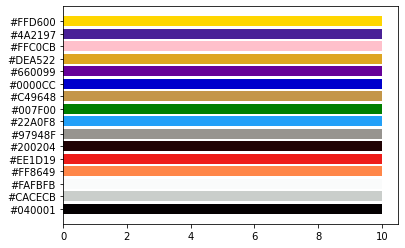

In [631]:
for i,c in enumerate('#'+final_df.color_hex.unique()):
   plt.barh(c, width=10, color=c)

print(final_df.color_hex.unique())

In [625]:
final_df.color = final_df.color_hex.map({'040001':'чёрный','CACECB':'серебристый', 'FAFBFB':'белый', 'FF8649':'оранжевый', 'EE1D19':'красный', '200204':'коричневый', '97948F':'серый', '22A0F8':'голубой',
 '007F00':'зелёный', 'C49648':'бежевый', '0000CC':'синий', '660099':'пурпурный', 'DEA522':'золотистый', 'FFC0CB':'розовый', '4A2197':'фиолетовый', 'FFD600':'жёлтый'})

In [635]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82182 entries, 0 to 82181
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           82182 non-null  int64  
 1   id                   82182 non-null  int64  
 2   body_type            82182 non-null  object 
 3   brand                82182 non-null  object 
 4   color_hex            82182 non-null  object 
 5   color                82182 non-null  object 
 6   complectation_dict   82182 non-null  object 
 7   description          82182 non-null  object 
 8   engineDisplacement   82182 non-null  object 
 9   enginePower          82182 non-null  object 
 10  equipment_dict       82182 non-null  object 
 11  fuelType             82182 non-null  object 
 12  mileage              82182 non-null  int64  
 13  modelDate            82182 non-null  float64
 14  model_info           82182 non-null  object 
 15  model_name           82182 non-null 

In [636]:
final_df.to_csv("auto_ru_v2.csv")

In [1]:
import re